<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-подготовка" data-toc-modified-id="Загрузка-и-подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и подготовка</a></span><ul class="toc-item"><li><span><a href="#Выводы:" data-toc-modified-id="Выводы:-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Выводы:</a></span></li></ul></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span><ul class="toc-item"><li><span><a href="#Проверка-структуры-и-пропусков" data-toc-modified-id="Проверка-структуры-и-пропусков-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Проверка структуры и пропусков</a></span></li><li><span><a href="#Визуализации" data-toc-modified-id="Визуализации-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Визуализации</a></span></li><li><span><a href="#Декомпозиция-ряда" data-toc-modified-id="Декомпозиция-ряда-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Декомпозиция ряда</a></span></li><li><span><a href="#Обработка-выбросов" data-toc-modified-id="Обработка-выбросов-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Обработка выбросов</a></span></li></ul></li><li><span><a href="#Корреляционный-анализ-и-создание-признаков" data-toc-modified-id="Корреляционный-анализ-и-создание-признаков-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Корреляционный анализ и создание признаков</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Baseline" data-toc-modified-id="Baseline-4.0.1"><span class="toc-item-num">4.0.1&nbsp;&nbsp;</span>Baseline</a></span></li><li><span><a href="#Диагностика-причины" data-toc-modified-id="Диагностика-причины-4.0.2"><span class="toc-item-num">4.0.2&nbsp;&nbsp;</span>Диагностика причины</a></span></li><li><span><a href="#Исправление-признаков" data-toc-modified-id="Исправление-признаков-4.0.3"><span class="toc-item-num">4.0.3&nbsp;&nbsp;</span>Исправление признаков</a></span></li></ul></li><li><span><a href="#Проверка-исправления" data-toc-modified-id="Проверка-исправления-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Проверка исправления</a></span></li><li><span><a href="#Подбор-гиперпараметров" data-toc-modified-id="Подбор-гиперпараметров-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Подбор гиперпараметров</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод:" data-toc-modified-id="Общий-вывод:-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Общий вывод:</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
%matplotlib inline

# стандартные библиотеки
import numpy as np
import pandas as pd

# библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

# анализ временных рядов
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

# модели машинного обучения
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# инструменты для оценки и предобработки моделей
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# статистический анализ
from statsmodels.stats.outliers_influence import variance_inflation_factor

# константы
RANDOM_STATE = 42
TEST_SIZE = 0.1
plt.rcParams['figure.dpi'] = 100

## Загрузка и подготовка

In [2]:
try:
    df = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'])
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', parse_dates=['datetime'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


None

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


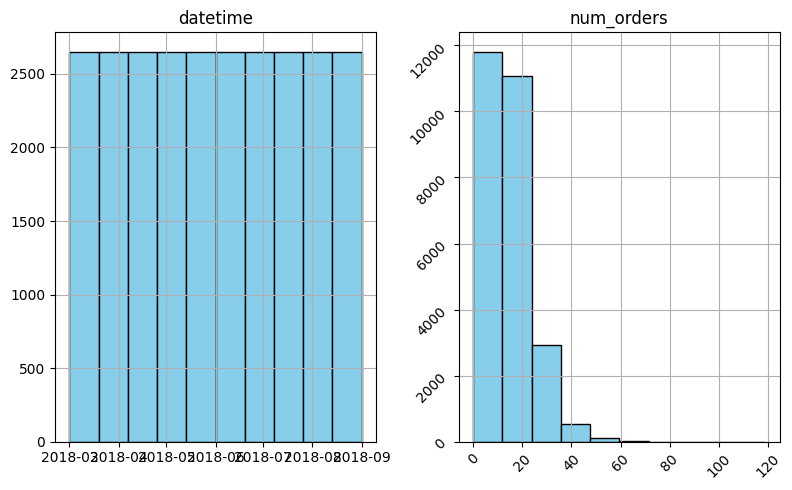

In [3]:
def check_df(df):
    display(df.info())
    display(df.head())
    display(df.describe())

    df.hist(figsize=(8,5), color='skyblue', edgecolor='black')
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(rotation=45, fontsize=10)
    plt.tight_layout()
    plt.show()

    print()

check_df(df)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


None

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


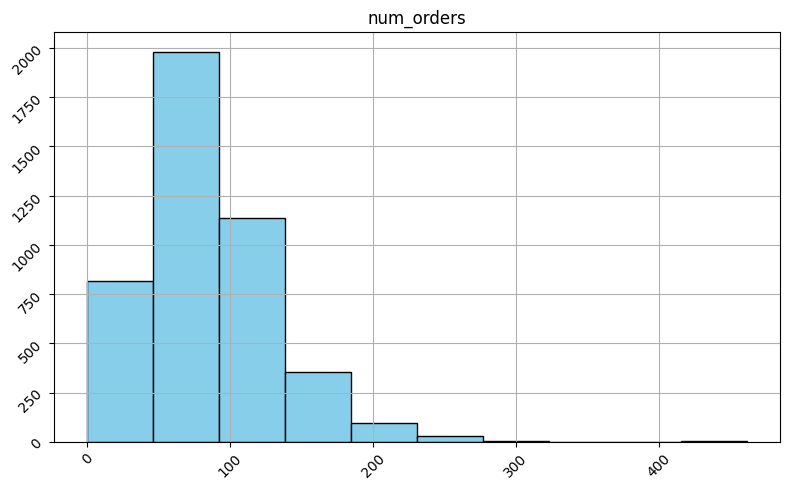

In [4]:
# Ресемплирование данных
df = df.resample('1h', on='datetime').sum()
check_df(df)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


### Выводы:
- До ресемплирования
    - Датасет загружен из `/datasets/taxi.csv` (26,496 строк, столбцы: `datetime`, `num_orders`).
    - `datetime` преобразован в `datetime64[ns]`, пропусков нет.
    - Временной диапазон: 2018-03-01 00:00:00 — 2018-08-31 23:50:00, гранулярность — 10 минут.
    - Статистика `num_orders`: среднее 14.07, медиана 13, минимум 0, максимум 119 (потенциальный выброс).
    - Гистограмма подтверждает левое смещение распределения, возможны выбросы.


- После ресемплирования  
    - Данные ресемплированы по часу, получено 4,416 строк.
    - Временной диапазон: 2018-03-01 00:00:00 — 2018-08-31 23:00:00.
    - `num_orders` агрегирован суммированием, максимум > 400 заказов/час.

## Исследовательский анализ данных

Цели EDA:
- Провести исследовательский анализ данных (EDA) для понимания структуры временного ряда, выявления трендов, сезонности, аномалий и других закономерностей.
- Сформировать гипотезы для создания признаков и выбора моделей.

### Проверка структуры и пропусков

Подтвердим отсутствие пропусков, проверим частоту индекса, проверим данные на наличие явных дубликатов после ресемплирования.

In [6]:
print('\nПропуски:\n', df.isna().sum())
print('\nЧастота индекса:', df.index.freq)
print('\nВременной диапазон:', df.index.min(), '—', df.index.max())
print('\nДубоикаты:', df.index.duplicated().sum())


Пропуски:
 num_orders    0
dtype: int64

Частота индекса: <Hour>

Временной диапазон: 2018-03-01 00:00:00 — 2018-08-31 23:00:00

Дубоикаты: 0


- Частота: 1 час.
- Пропусков нет, временной диапазон: 2018-03-01 00:00:00 — 2018-08-31 23:00:00.
- Частота индекса подтверждена ('H').
- Явных дубликатов нет.

### Визуализации

Построим графики для оценки трендов, сезонности и выбросов.

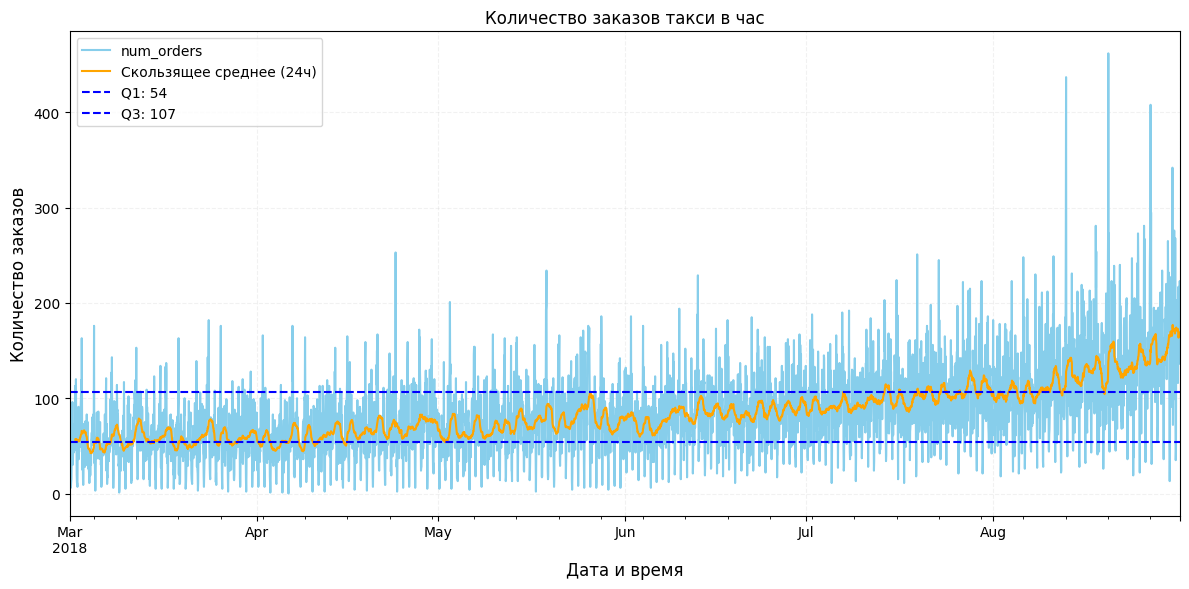

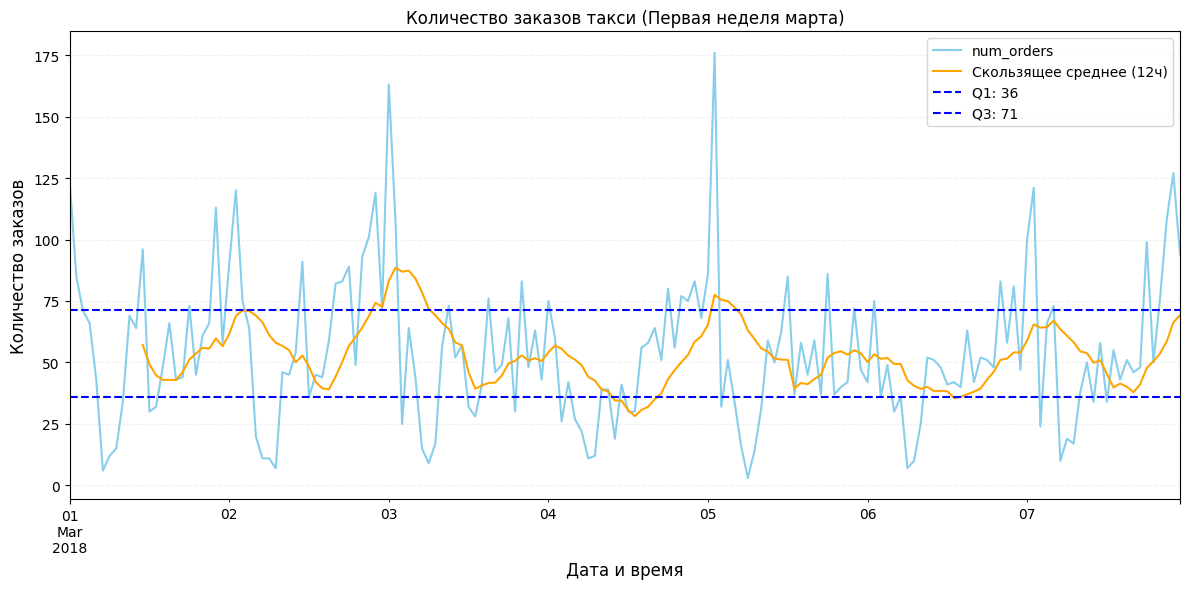

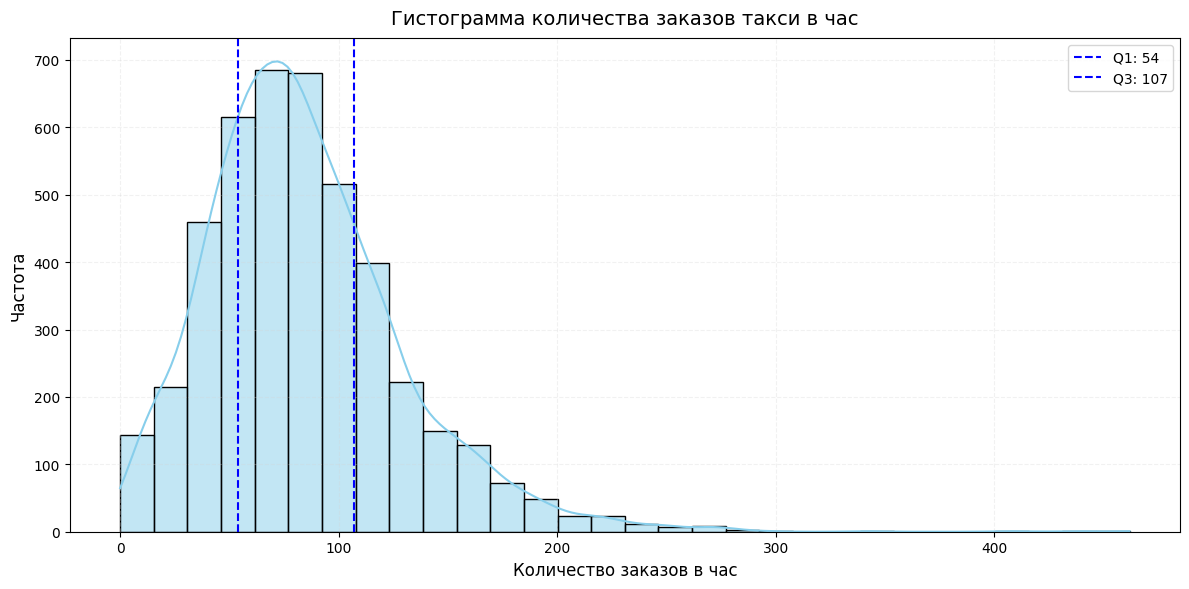

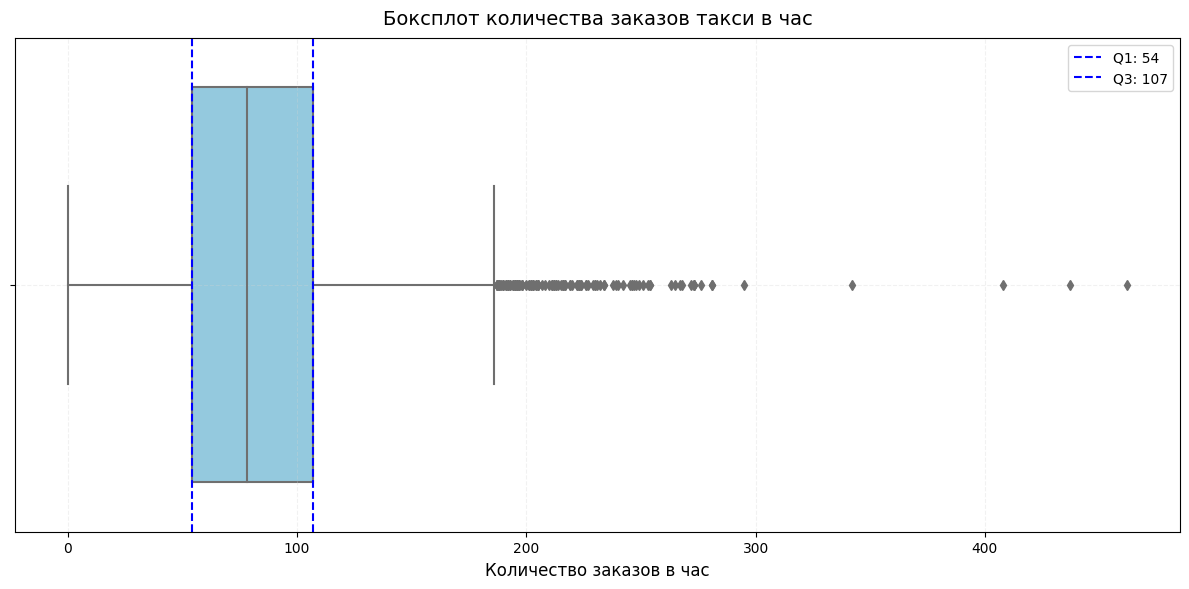

In [7]:
# график всего временного ряда
plt.figure(figsize=(12, 6))
df['num_orders'].plot(title='Количество заказов такси в час', color='skyblue')
# добавление скользящего среднего (24 часа)
df['num_orders'].rolling(window=24).mean().plot(color='orange', label='Скользящее среднее (24ч)')
# вычисление и добавление IQR
Q1 = df['num_orders'].quantile(0.25)
Q3 = df['num_orders'].quantile(0.75)
plt.axhline(Q1, color='blue', linestyle='--', label=f'Q1: {Q1:.0f}')
plt.axhline(Q3, color='blue', linestyle='--', label=f'Q3: {Q3:.0f}')
plt.xlabel('Дата и время', fontsize=12)
plt.ylabel('Количество заказов', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3, color='#D3D3D3')
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

# график за неделю (для сезонности)
df_week = df['2018-03-01':'2018-03-07']
plt.figure(figsize=(12, 6))
df_week['num_orders'].plot(title='Количество заказов такси (Первая неделя марта)', color='skyblue')
# добавление скользящего среднего (12 часов)
df_week['num_orders'].rolling(window=12).mean().plot(color='orange', label='Скользящее среднее (12ч)')
# вычисление и добавление IQR
Q1_week = df_week['num_orders'].quantile(0.25)
Q3_week = df_week['num_orders'].quantile(0.75)
plt.axhline(Q1_week, color='blue', linestyle='--', label=f'Q1: {Q1_week:.0f}')
plt.axhline(Q3_week, color='blue', linestyle='--', label=f'Q3: {Q3_week:.0f}')
plt.xlabel('Дата и время', fontsize=12)
plt.ylabel('Количество заказов', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3, color='#D3D3D3')
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

# гистограмма с KDE
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='num_orders', bins=30, kde=True, color='skyblue')
# вычисление и добавление IQR
Q1 = df['num_orders'].quantile(0.25)
Q3 = df['num_orders'].quantile(0.75)
plt.axvline(Q1, color='blue', linestyle='--', label=f'Q1: {Q1:.0f}')
plt.axvline(Q3, color='blue', linestyle='--', label=f'Q3: {Q3:.0f}')
plt.title('Гистограмма количества заказов такси в час', fontsize=14, pad=10)
plt.xlabel('Количество заказов в час', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3, color='#D3D3D3')
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

# боксплот для анализа выбросов
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='num_orders', color='skyblue')
# вычисление и добавление IQR
Q1 = df['num_orders'].quantile(0.25)
Q3 = df['num_orders'].quantile(0.75)
plt.axvline(Q1, color='blue', linestyle='--', label=f'Q1: {Q1:.0f}')
plt.axvline(Q3, color='blue', linestyle='--', label=f'Q3: {Q3:.0f}')
plt.title('Боксплот количества заказов такси в час', fontsize=14, pad=10)
plt.xlabel('Количество заказов в час', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3, color='#D3D3D3')
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

- График за 6 месяцев: сильно выраженного тренда нет, но небольшой рост количества заказов с каждым месяцем заметен, а в августе происходит самый сильный рост заказов (вероятно, это связано с возвращением людей домой из летних отпусков и повышенной загрузкой аэропортов). На графике в целом, присутствуют пики (>400 заказов/час), указывающие на выбросы.
- График за неделю: подтверждена дневная сезонность (пики ~100–150 каждые 24 часа). В первой половине суток (ночью и утром) заметно сильное падение спроса с последующим восстановлением и пиками ближе к вечеру.
- Гистограмма: левое смещение, пик 100–150 заказов, выбросы >300, распределение почти похоже на нормальное.
- Боксплот: медиана ~100, IQR 50–110, выбросы >200, требуют анализа.

### Декомпозиция ряда

Выделим сезонность и остатки.

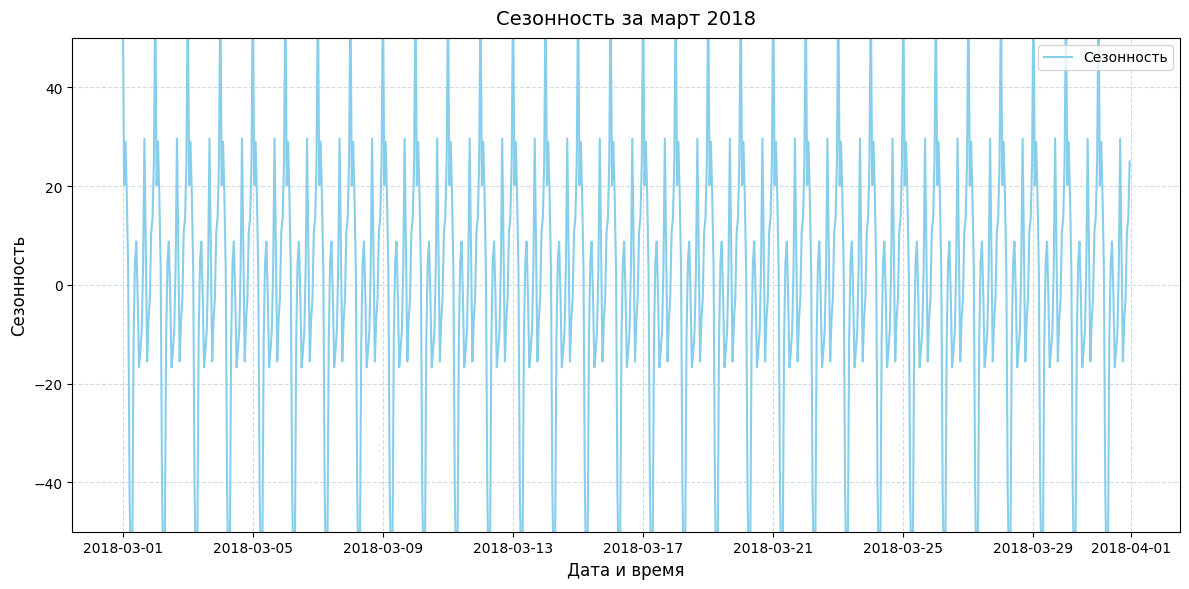

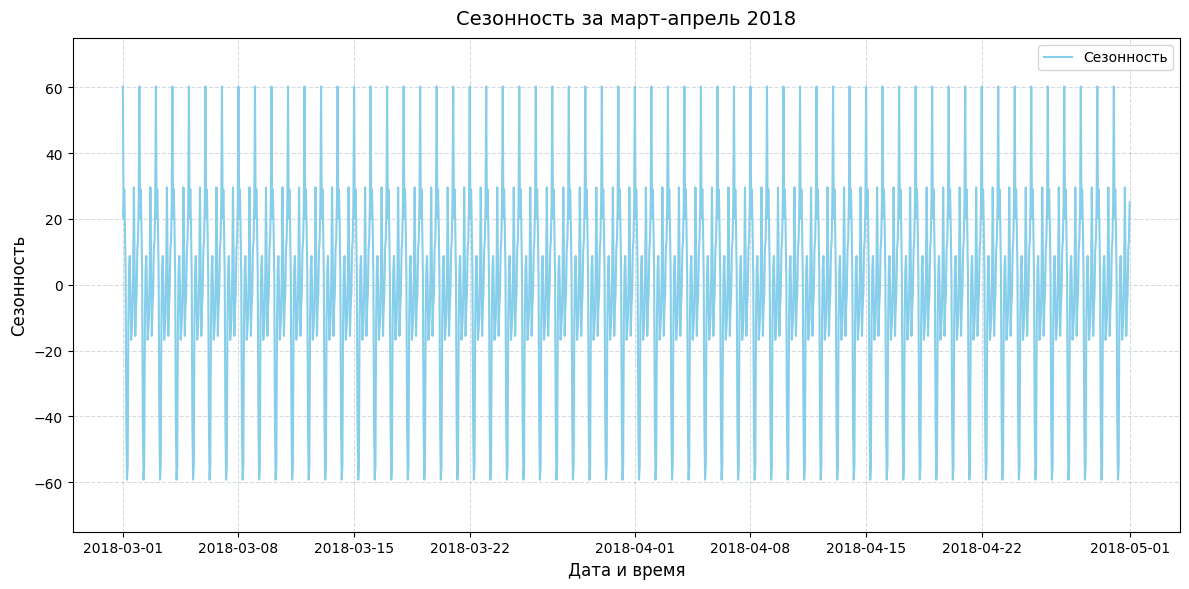

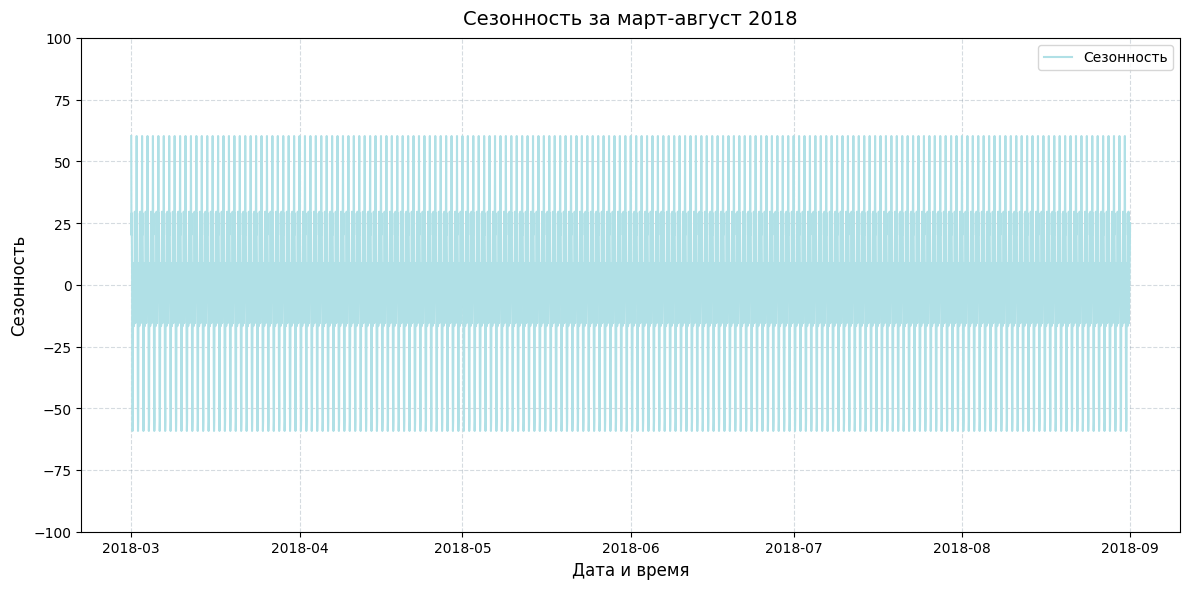

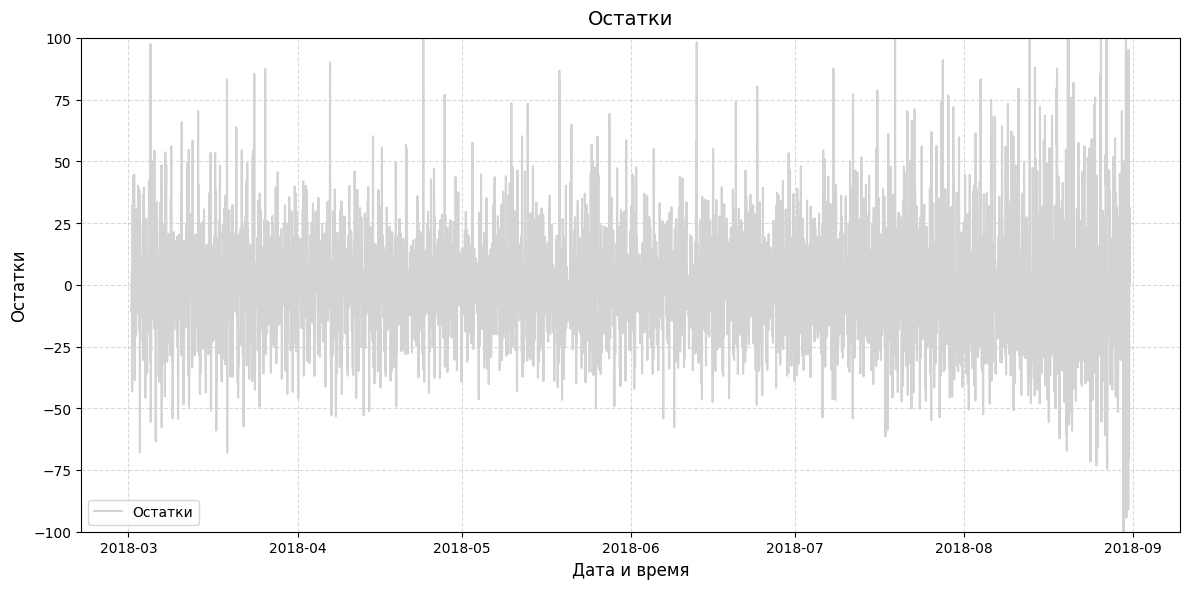

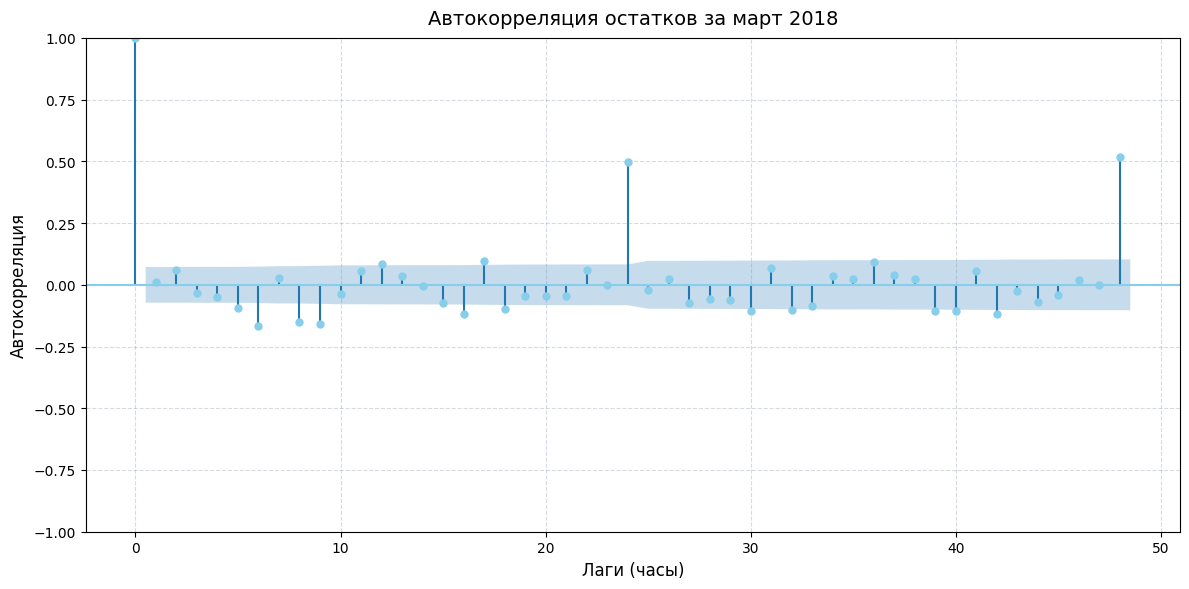

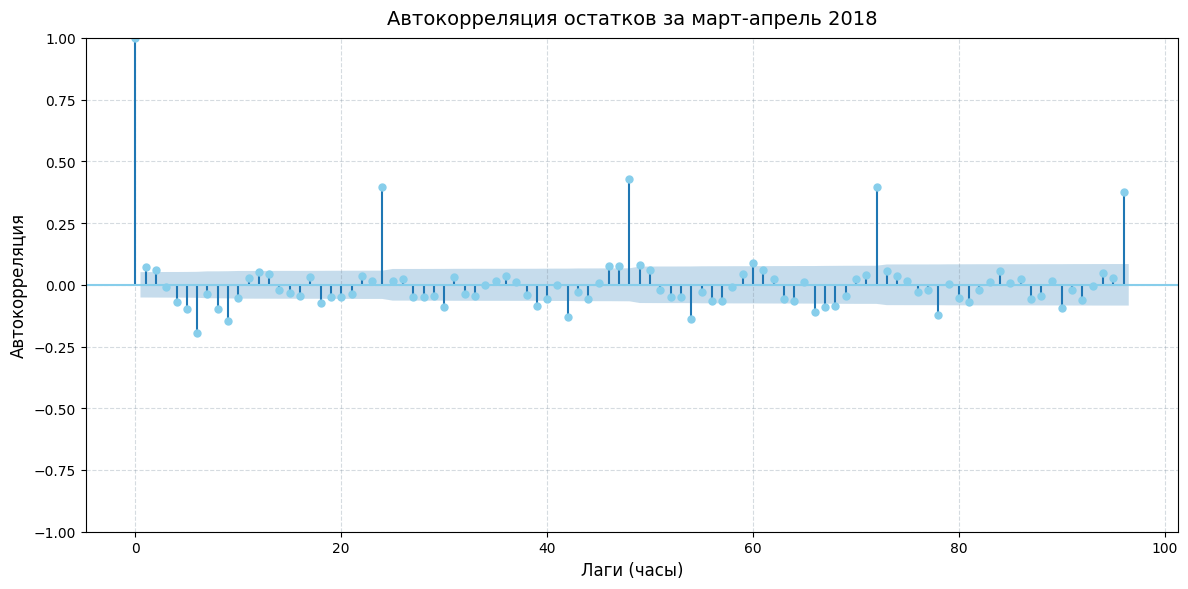

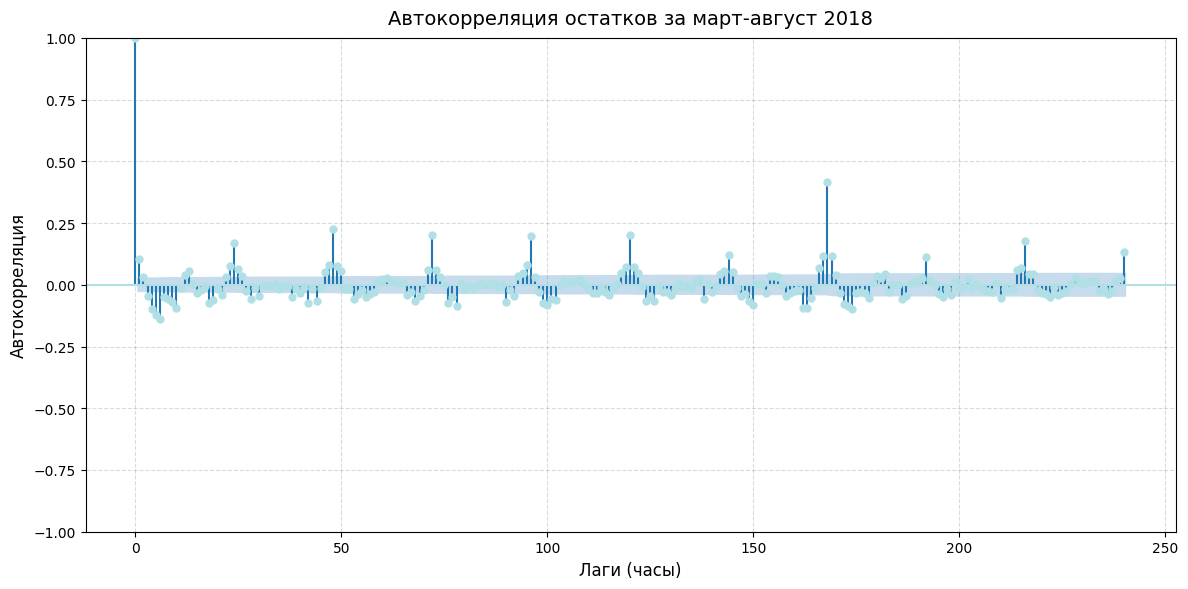

In [8]:
decomposition_add = seasonal_decompose(df['num_orders'], model='additive', period=24)

# сезонность за 1 месяц (март)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(decomposition_add.seasonal['2018-03-01':'2018-03-31'], color='skyblue', label='Сезонность')
ax.set_title('Сезонность за март 2018', fontsize=14, pad=10)
ax.set_xlabel('Дата и время', fontsize=12)
ax.set_ylabel('Сезонность', fontsize=12)
ax.set_ylim(-50, 50)
ax.grid(True, linestyle='--', alpha=0.3, color='#778899')
ax.legend(fontsize=10)
plt.tight_layout()
plt.show()

# сезонность за 2 месяца (март-апрель)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(decomposition_add.seasonal['2018-03-01':'2018-04-30'], color='#87CEEB', label='Сезонность')
ax.set_title('Сезонность за март-апрель 2018', fontsize=14, pad=10)
ax.set_xlabel('Дата и время', fontsize=12)
ax.set_ylabel('Сезонность', fontsize=12)
ax.set_ylim(-75, 75)
ax.grid(True, linestyle='--', alpha=0.3, color='#778899')
ax.legend(fontsize=10)
plt.tight_layout()
plt.show()

# сезонность за 6 месяцев
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(decomposition_add.seasonal, color='#B0E0E6', label='Сезонность')
ax.set_title('Сезонность за март-август 2018', fontsize=14, pad=10)
ax.set_xlabel('Дата и время', fontsize=12)
ax.set_ylabel('Сезонность', fontsize=12)
ax.set_ylim(-100, 100)
ax.grid(True, linestyle='--', alpha=0.3, color='#778899')
ax.legend(fontsize=10)
plt.tight_layout()
plt.show()

# остатки за 6 месяцев
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(decomposition_add.resid, color='#D3D3D3', label='Остатки')
ax.set_title('Остатки', fontsize=14, pad=10)
ax.set_xlabel('Дата и время', fontsize=12)
ax.set_ylabel('Остатки', fontsize=12)
ax.set_ylim(-100, 100)
ax.grid(True, linestyle='--', alpha=0.3, color='#778899')
ax.legend(fontsize=10)
plt.tight_layout()
plt.show()

# автокорреляция остатков - 1 месяц
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(decomposition_add.resid['2018-03-01':'2018-03-31'].dropna(), lags=48, ax=ax, color='skyblue', alpha=0.05)
ax.set_title('Автокорреляция остатков за март 2018', fontsize=14, pad=10)
ax.set_xlabel('Лаги (часы)', fontsize=12)
ax.set_ylabel('Автокорреляция', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.3, color='#778899')
plt.tight_layout()
plt.show()

# автокорреляция остатков - 2 месяца
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(decomposition_add.resid['2018-03-01':'2018-04-30'].dropna(), lags=96, ax=ax, color='#87CEEB', alpha=0.05)
ax.set_title('Автокорреляция остатков за март-апрель 2018', fontsize=14, pad=10)
ax.set_xlabel('Лаги (часы)', fontsize=12)
ax.set_ylabel('Автокорреляция', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.3, color='#778899')
plt.tight_layout()
plt.show()

# автокорреляция остатков - 6 месяцев
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(decomposition_add.resid.dropna(), lags=240, ax=ax, color='#B0E0E6', alpha=0.05)
ax.set_title('Автокорреляция остатков за март-август 2018', fontsize=14, pad=10)
ax.set_xlabel('Лаги (часы)', fontsize=12)
ax.set_ylabel('Автокорреляция', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.3, color='#778899')
plt.tight_layout()
plt.show()

**Выводы по графикам:**

- **Сезонность:** Графики за 1, 2 и 6 месяцев демонстрируют периодичность с периодом 24 часа, амплитуда растёт с увеличением масштаба (от -50:50 до -100:100), что указывает на устойчивую суточную структуру ряда.

- **Остатки:** График остатков за 6 месяцев показывает случайный шум с пиками около нуля, что подтверждает адекватность модели декомпозиции на данном этапе.

- **Автокорреляция:** Графики ACF с лагами 48, 96 и 240 выявляют значимые пики на кратных 24, что подтверждает наличие сезонности.

### Обработка выбросов

Несмотря на то, что мы выяснили, что выбросы в этих данных не являются ошибками или аномалиями, а лишь следствиями необычных событий, выполним их клиппинг, чтобы сгладить "острые" углы и улучшить интерпретируемость будущей модели.

- Добавим в данные следующие признаки:
  - **Календарные признаки:** hour (час), dayofweek (день недели) и is_weekend (бинарный флаг выходных, 1 для субботы и воскресенья, 0 для будней). Основаные на индексе datetime ряда. Hour и dayofweek отражают суточную и недельную сезонность, подтверждённую визуальным анализом (графики сезонности с периодом 24) и ACF (пики на кратных 24). Is_weekend учитывает потенциальные различия в спросе в выходные, что типично для такси в аэропортах.
  - **Лаги:** 24 лага (lag_1 до lag_24), представляющих значения num_orders за предыдущие 24 часа. Вычислим с использованием метода shift(). 24 лага выбраны на основе периода сезонности (24 часа), чтобы захватить автокорреляционные зависимости, выявленные в ACF (значимые пики до 48 лагов). Это обеспечит модели доступ к историческим паттернам.
  - **Скользящие статистики:** Рассчитаны rolling_mean и rolling_std для окон 3, 6, 12 и 24 часа. Реализованы через rolling().mean() и rolling().std() с последующим удалением NaN через dropna(). Окна 3, 6, 12, 24 выбраны для моделирования локальных трендов и волатильности на разных масштабах (от краткосрочных пиков до суточных циклов), что улучшает предсказательную способность для регрессии.

In [9]:
# анализ выбросов
q1 = df['num_orders'].quantile(0.25)
q3 = df['num_orders'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# подсчёт выбросов
outliers = df[(df['num_orders'] < lower_bound) | (df['num_orders'] > upper_bound)]
print(f'выбросы: {len(outliers)} из {len(df)} ({len(outliers)/len(df):.2%})')

# клиппинг выбросов
df['num_orders_clipped'] = np.clip(df['num_orders'], lower_bound, upper_bound)

# создание признаков
# календарные признаки
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)

# лаги
for lag in range(1, 25):
    df[f'lag_{lag}'] = df['num_orders_clipped'].shift(lag)

# скользящие статистики
windows = [3, 6, 12, 24]
for w in windows:
    df[f'rolling_mean_{w}'] = df['num_orders_clipped'].rolling(w).mean()
    df[f'rolling_std_{w}'] = df['num_orders_clipped'].rolling(w).std()

# удаление na
df = df.dropna()

# проверка признаков
display(df.head())
df.info()

выбросы: 121 из 4416 (2.74%)


,num_orders,num_orders_clipped,hour,dayofweek,is_weekend,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_23,lag_24,rolling_mean_3,rolling_std_3,rolling_mean_6,rolling_std_6,rolling_mean_12,rolling_std_12,rolling_mean_24,rolling_std_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,90.0,0,4,0,58.0,113.0,66.0,61.0,45.0,...,85.0,124.0,87.000000,27.622455,72.166667,24.846864,61.583333,22.609163,55.416667,26.730404
2018-03-02 01:00:00,120,120.0,1,4,0,90.0,58.0,113.0,66.0,61.0,...,71.0,85.0,89.333333,31.005376,84.666667,27.200490,68.916667,26.137602,56.875000,29.250511
2018-03-02 02:00:00,75,75.0,2,4,0,120.0,90.0,58.0,113.0,66.0,...,66.0,71.0,95.000000,22.912878,87.000000,25.298221,71.166667,25.322765,57.041667,29.345734
2018-03-02 03:00:00,64,64.0,3,4,0,75.0,120.0,90.0,58.0,113.0,...,43.0,66.0,86.333333,29.670412,86.666667,25.641113,71.000000,25.366406,56.958333,29.322019
2018-03-02 04:00:00,20,20.0,4,4,0,64.0,75.0,120.0,90.0,58.0,...,6.0,43.0,53.000000,29.103264,71.166667,33.456937,69.083333,28.365979,56.000000,30.161882


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4392 entries, 2018-03-02 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 37 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   num_orders          4392 non-null   int64  
 1   num_orders_clipped  4392 non-null   float64
 2   hour                4392 non-null   int64  
 3   dayofweek           4392 non-null   int64  
 4   is_weekend          4392 non-null   int64  
 5   lag_1               4392 non-null   float64
 6   lag_2               4392 non-null   float64
 7   lag_3               4392 non-null   float64
 8   lag_4               4392 non-null   float64
 9   lag_5               4392 non-null   float64
 10  lag_6               4392 non-null   float64
 11  lag_7               4392 non-null   float64
 12  lag_8               4392 non-null   float64
 13  lag_9               4392 non-null   float64
 14  lag_10              4392 non-null   float64
 15  lag_11     

Признаки добавлены успешно. Далее проверим мультиколлинеарность между признаками и выявим, какие признаки сильнее всего влияют на таргет. Неинформативные признаки удалим.

## Корреляционный анализ и создание признаков

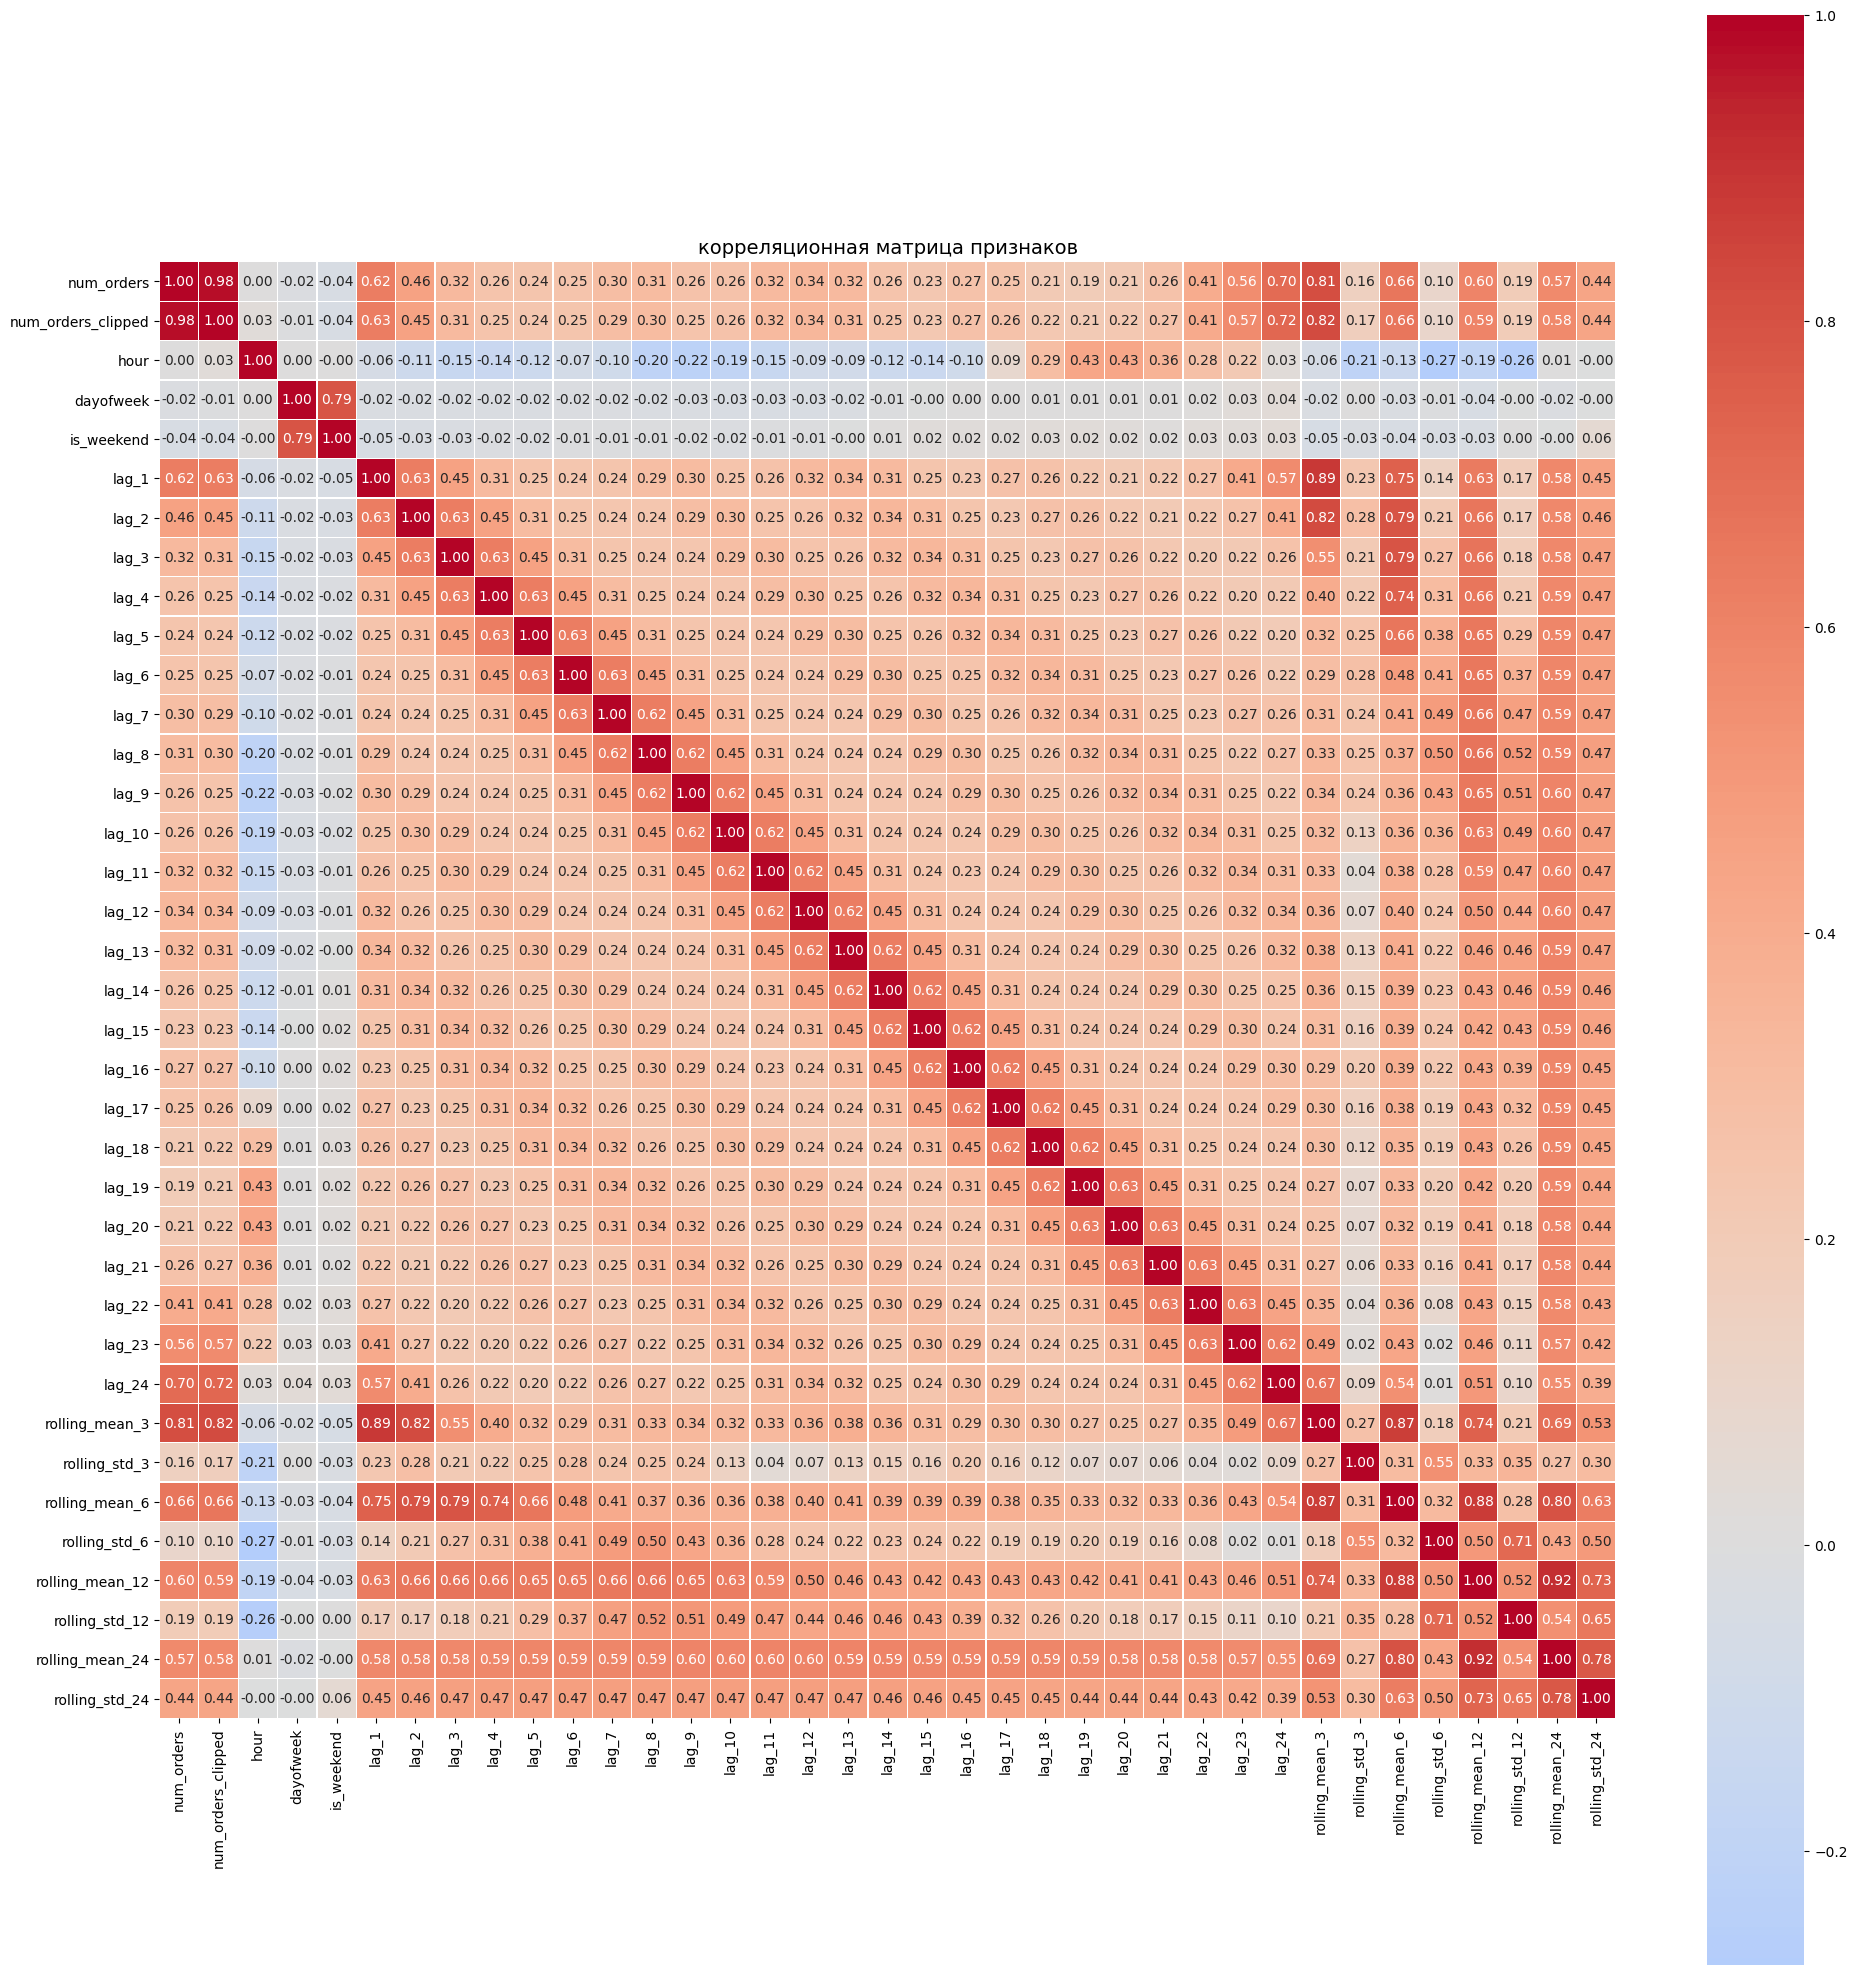

In [10]:
# выбор числовых признаков
numeric_cols = df.select_dtypes(include=['int64', 'int32', 'float64']).columns
corr_matrix = df[numeric_cols].corr()

# визуализация heatmap
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0, square=True, linewidths=0.2)
ax.set_title('корреляционная матрица признаков', fontsize=14)
plt.tight_layout()
plt.show()

In [11]:
# выбор числовых признаков
numeric_cols = df.select_dtypes(include=['int64', 'int32', 'float64']).columns
corr_matrix = df[numeric_cols].corr()

# фильтрация высокой корреляции (|ρ| > 0.9, исключая диагональ и целевую)
high_corr = corr_matrix[(abs(corr_matrix) > 0.9) & (corr_matrix != 1) & 
                       (corr_matrix.index != 'num_orders_clipped') & 
                       (corr_matrix.columns != 'num_orders_clipped')]

# отбор пар с высокой корреляцией
pairs = high_corr.stack().reset_index()
pairs = pairs[pairs[0] != 0]  # удаление нулевых
pairs.columns = ['feature1', 'feature2', 'corr']

# отображение пар
print('пары с |ρ| > 0.9:')
display(pairs)

# удаление одного из пары
cols_to_drop_high = set(pairs['feature2'])

# слабая корреляция с целевой (|ρ| < 0.1 с num_orders_clipped)
target_corr = corr_matrix['num_orders_clipped'][abs(corr_matrix['num_orders_clipped']) < 0.1]
cols_to_drop_low = set(target_corr.index) - {'num_orders_clipped'}  # исключаем целевую

# объединение списков удаления
cols_to_drop = cols_to_drop_high.union(cols_to_drop_low)

# удаление
df_clean = df.drop(columns=list(cols_to_drop))
display(f'удалено признаков: {len(cols_to_drop)}')

# отображение очищенного df
display(df_clean.head())
df_clean.info()

пары с |ρ| > 0.9:


,feature1,feature2,corr
0,num_orders_clipped,num_orders,0.978857
1,rolling_mean_12,rolling_mean_24,0.917477
2,rolling_mean_24,rolling_mean_12,0.917477


'удалено признаков: 7'

,num_orders_clipped,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean_3,rolling_std_3,rolling_mean_6,rolling_std_12,rolling_std_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90.0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,43.0,66.0,...,43.0,66.0,71.0,85.0,124.0,87.000000,27.622455,72.166667,22.609163,26.730404
2018-03-02 01:00:00,120.0,90.0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,43.0,...,6.0,43.0,66.0,71.0,85.0,89.333333,31.005376,84.666667,26.137602,29.250511
2018-03-02 02:00:00,75.0,120.0,90.0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,...,12.0,6.0,43.0,66.0,71.0,95.000000,22.912878,87.000000,25.322765,29.345734
2018-03-02 03:00:00,64.0,75.0,120.0,90.0,58.0,113.0,66.0,61.0,45.0,73.0,...,15.0,12.0,6.0,43.0,66.0,86.333333,29.670412,86.666667,25.366406,29.322019
2018-03-02 04:00:00,20.0,64.0,75.0,120.0,90.0,58.0,113.0,66.0,61.0,45.0,...,34.0,15.0,12.0,6.0,43.0,53.000000,29.103264,71.166667,28.365979,30.161882


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4392 entries, 2018-03-02 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   num_orders_clipped  4392 non-null   float64
 1   lag_1               4392 non-null   float64
 2   lag_2               4392 non-null   float64
 3   lag_3               4392 non-null   float64
 4   lag_4               4392 non-null   float64
 5   lag_5               4392 non-null   float64
 6   lag_6               4392 non-null   float64
 7   lag_7               4392 non-null   float64
 8   lag_8               4392 non-null   float64
 9   lag_9               4392 non-null   float64
 10  lag_10              4392 non-null   float64
 11  lag_11              4392 non-null   float64
 12  lag_12              4392 non-null   float64
 13  lag_13              4392 non-null   float64
 14  lag_14              4392 non-null   float64
 15  lag_15     

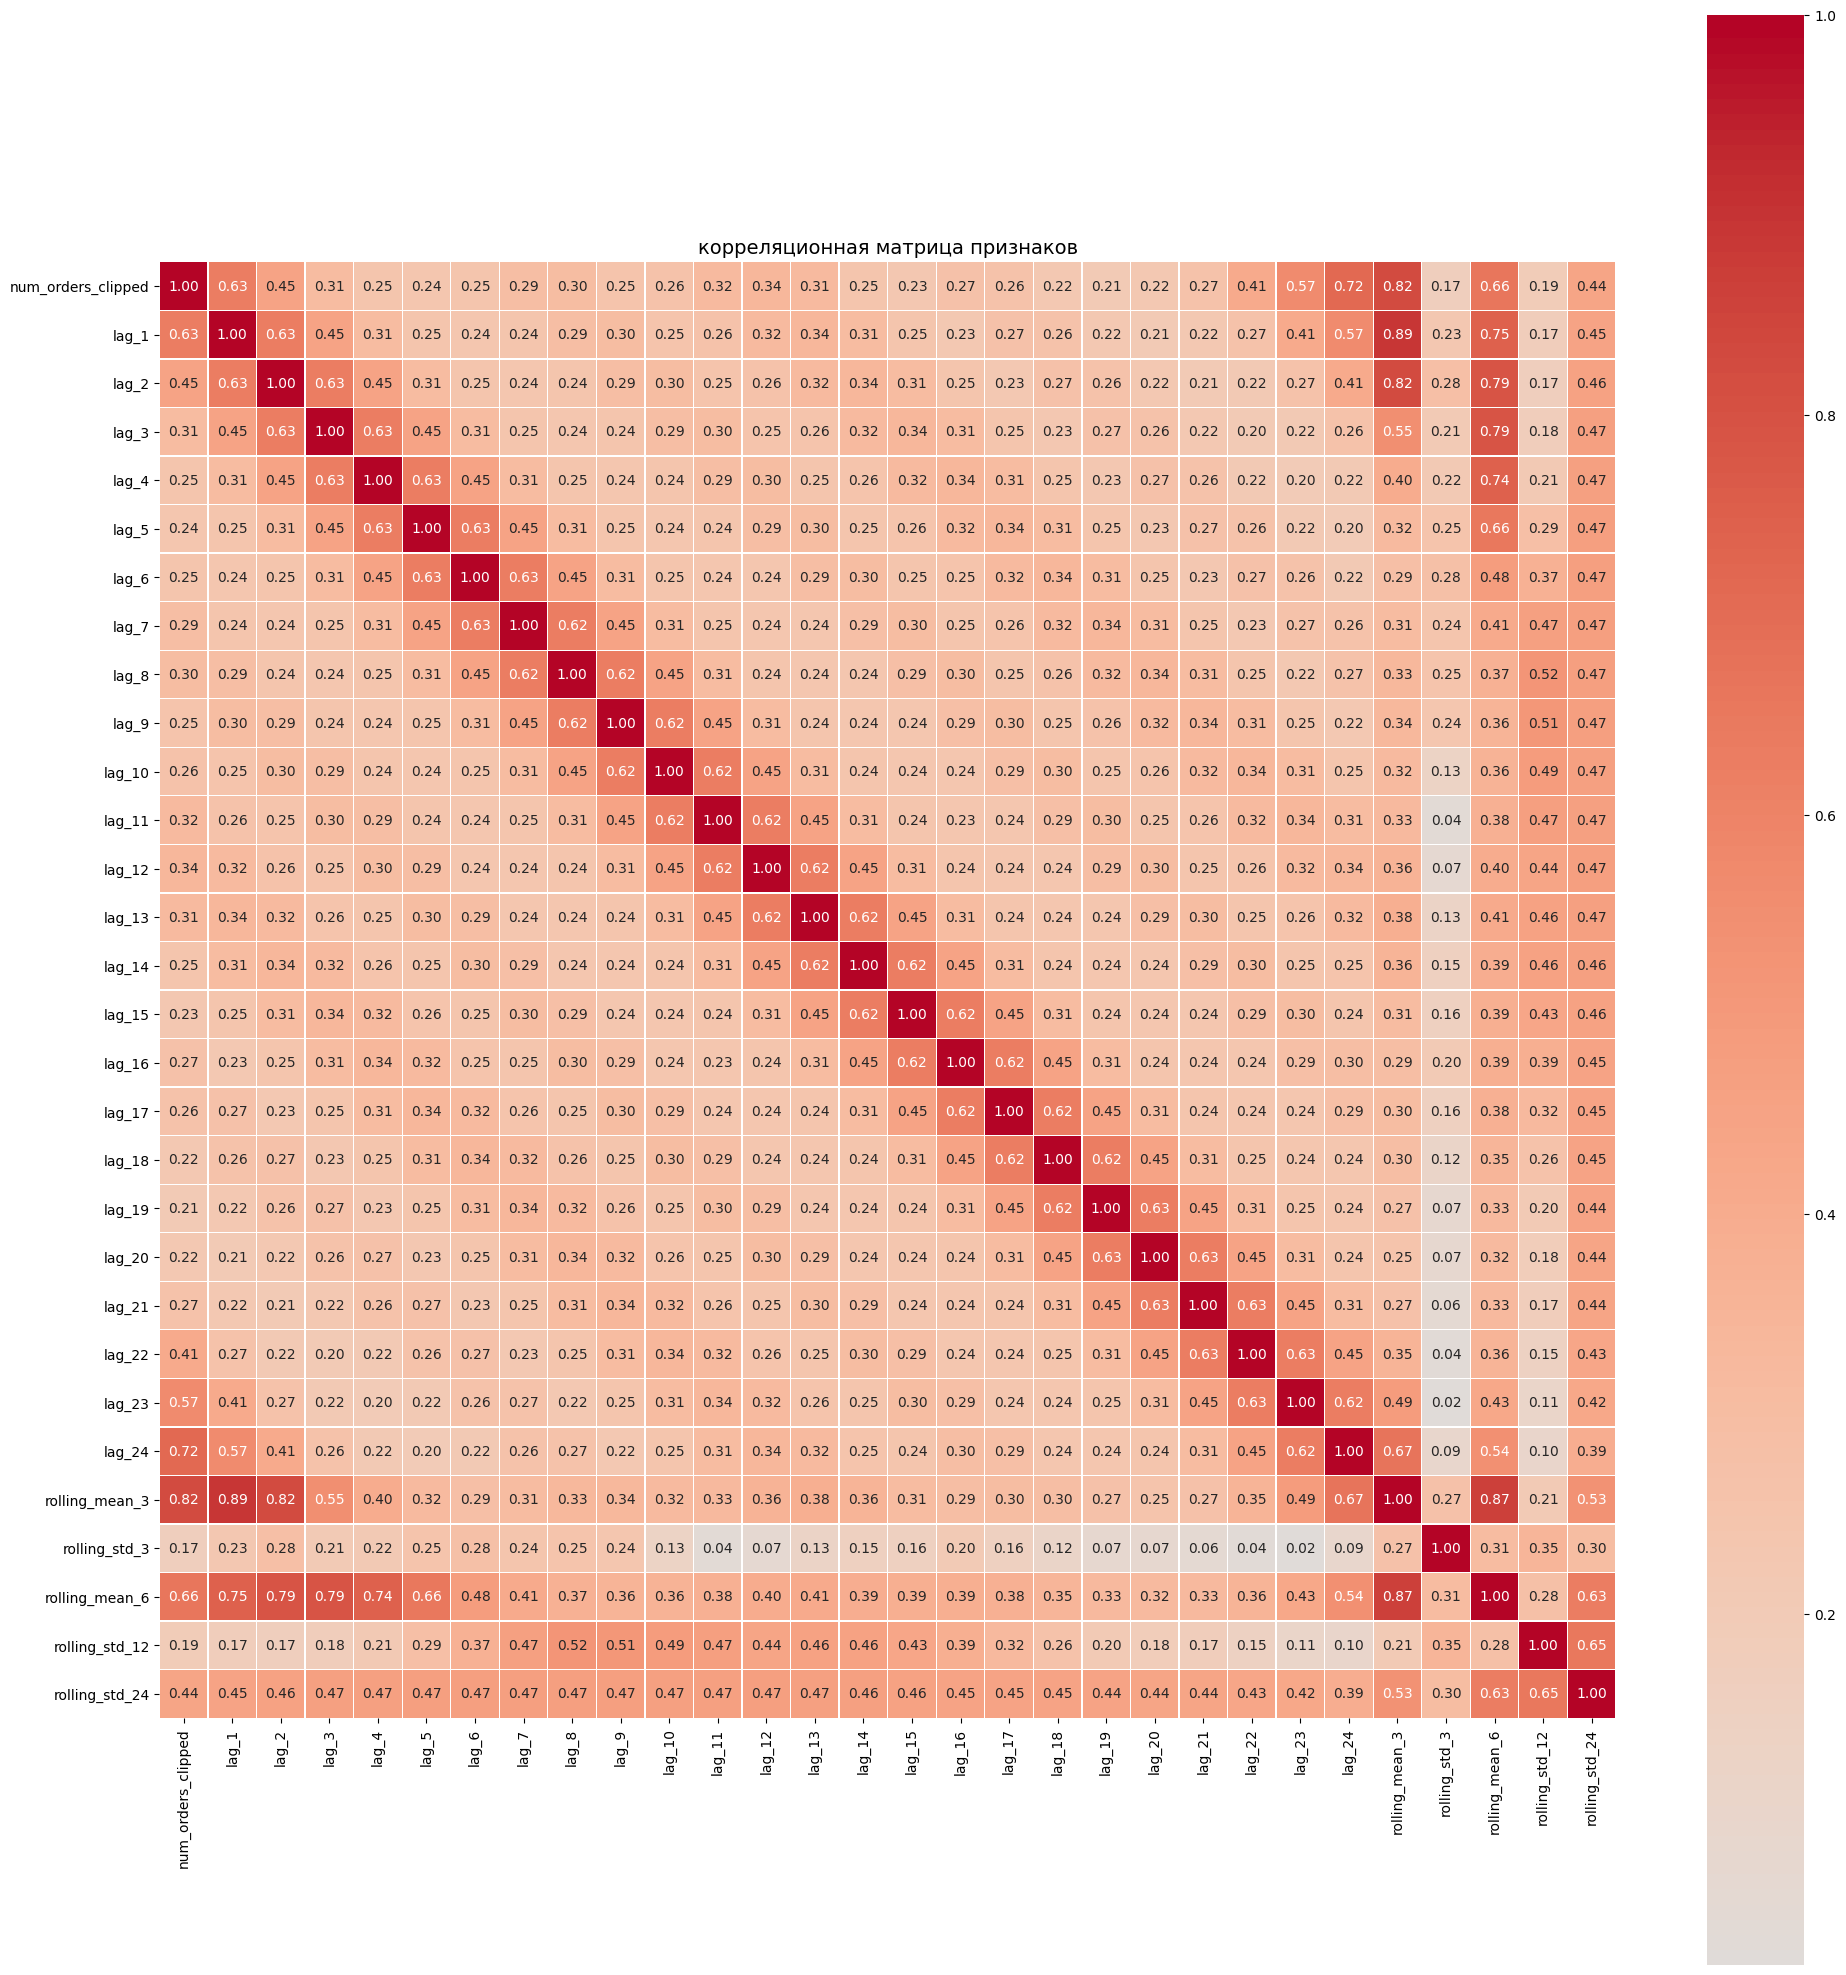

In [12]:
# выбор числовых признаков
numeric_cols = df_clean.select_dtypes(include=['int64', 'int32', 'float64']).columns
corr_matrix = df_clean[numeric_cols].corr()

# визуализация heatmap
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0, square=True, linewidths=0.2)
ax.set_title('корреляционная матрица признаков', fontsize=14)
plt.tight_layout()
plt.show()

Получилось отлично. Исключив слабые и мультиколинеарные признаки, осталось 29 информативных признаков. Перейдем к обучению.

## Обучение

In [13]:
num_cols = list(set(df_clean.columns) - {'num_orders_clipped'})

In [14]:
# подготовка данных
X = df_clean.drop(columns=['num_orders_clipped'])
y = df_clean['num_orders_clipped']

# сплит
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    shuffle=False
)

In [15]:
print(X_train.index[-1])
print(X_test.index[0])
X_train.shape, y_train.shape, X_test.shape, y_test.shape

2018-08-13 15:00:00
2018-08-13 16:00:00


((3952, 29), (3952,), (440, 29), (440,))

Данные последовательны

#### Baseline

In [16]:
# обучение линейной регрессии
model = LinearRegression()
model.fit(X_train, y_train)

# предсказания и оценка
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

residuals_train = y_train - y_pred_train
print(f"Baseline LR - Train RMSE: {train_rmse:.2f}")

Baseline LR - Train RMSE: 0.00


**Проблема**: rmse = 0. Такого не бывает, возможно где-то утечка данных.

#### Диагностика причины

- Проверим данные:
  - Высокая корреляция признаков с num_orders_clipped (>0.8) может подтвердить утечку.
  - Проверка VIF: высокие значения (>10) для rolling и лагов будут указывать на мультиколлинеарность.

In [17]:
# Проверка корреляции признаков с целевой переменной
correlations = X_train.corrwith(y_train).sort_values(ascending=False)
display("Корреляция признаков с num_orders_clipped:\n", correlations)

# Проверка мультиколлинеарности (VIF)
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

vif = calculate_vif(X_train)
display("VIF для признаков:\n", vif)

# Проверка первых строк X_train и y_train на предмет утечки
print("Первые 5 строк X_train (lag_1, rolling_mean_3):")
display(X_train[['lag_1', 'rolling_mean_3']].head())
print("Первые 5 строк y_train:")
display(y_train.head())

# Обучение модели Lasso
lasso_model = Lasso(alpha=0.1, random_state=42)
lasso_model.fit(X_train, y_train)

# Получение коэффициентов и значимых признаков
lasso_coef = pd.Series(lasso_model.coef_, index=X_train.columns)

print("Значимые признаки (Lasso):")
print(lasso_coef[lasso_coef.abs() > 1e-5])

'Корреляция признаков с num_orders_clipped:\n'

rolling_mean_3    0.795519
lag_24            0.667044
rolling_mean_6    0.603331
lag_1             0.567803
lag_23            0.489305
lag_2             0.388211
rolling_std_24    0.327531
lag_22            0.323189
lag_12            0.248850
lag_3             0.238037
lag_11            0.227974
lag_13            0.220437
lag_8             0.203091
rolling_std_3     0.193817
lag_7             0.187314
lag_21            0.177920
lag_16            0.164487
lag_4             0.160683
lag_10            0.159227
lag_17            0.146440
lag_14            0.144297
lag_5             0.141774
lag_9             0.139509
lag_6             0.130953
lag_15            0.116245
lag_20            0.115012
rolling_std_12    0.113501
lag_18            0.103584
lag_19            0.097174
dtype: float64

/opt/conda/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


'VIF для признаков:\n'

,feature,VIF
0,lag_1,30.099305
1,lag_2,26.427824
2,lag_3,inf
3,lag_4,inf
4,lag_5,inf
5,lag_6,11.219551
6,lag_7,11.533654
7,lag_8,11.669600
8,lag_9,11.605196
9,lag_10,11.483310


Первые 5 строк X_train (lag_1, rolling_mean_3):


,lag_1,rolling_mean_3
datetime,,
2018-03-02 00:00:00,58.0,87.000000
2018-03-02 01:00:00,90.0,89.333333
2018-03-02 02:00:00,120.0,95.000000
2018-03-02 03:00:00,75.0,86.333333
2018-03-02 04:00:00,64.0,53.000000


Первые 5 строк y_train:


datetime
2018-03-02 00:00:00     90.0
2018-03-02 01:00:00    120.0
2018-03-02 02:00:00     75.0
2018-03-02 03:00:00     64.0
2018-03-02 04:00:00     20.0
Freq: H, Name: num_orders_clipped, dtype: float64

Значимые признаки (Lasso):
lag_1            -1.000327
lag_2            -1.000212
lag_3             0.126958
lag_4             0.127066
lag_5             0.127103
lag_24           -0.000062
rolling_mean_3    3.381968
rolling_mean_6   -0.762320
dtype: float64


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3276.5583661597916, tolerance: 554.1693615131579
  model = cd_fast.enet_coordinate_descent(


- **Корреляции:**

  - rolling_mean_3: 0.795519 — высокая, возможна утечка.
  - lag_1: 0.567803 — ожидаемая для временного ряда (нормально).
  - lag_24: 0.667044 — указывает на сезонность (24-часовой цикл).


- **VIF:**

  - lag_3, lag_4, lag_5, rolling_mean_3, rolling_mean_6: бесконечность — сильная мультиколлинеарность.
  - lag_1: 30.10, rolling_std_24: 67.07 — высокая корреляция между признаками.


- **Анализ:**

  - Высокая корреляция rolling_mean_3 (0.80) и бесконечный VIF подтверждают, что rolling_mean_3 включает y(t), вызывая утечку.
  - Коэффициенты модели (lag_1: -1.0, rolling_mean_3: 3.38) показывают, что модель использует rolling_mean_3 для "вычисления" y(t): y(t) ≈ 3*rolling_mean_3 - lag_1 - lag_2.


**Вывод: Утечка подтверждена в rolling-статистиках. Лаги корректны (если lag_1 = y(t-1)).**

#### Исправление признаков

Пересчитаем роллин-сатитстки с shift(1), чтчобы исключить текущий момент t. Лаги сохраним, потому что они корректны.

In [18]:
# Пересчитываем rolling-статистики с shift(1)
windows = [3, 6, 12, 24]
for w in windows:
    df[f'rolling_mean_{w}'] = df['num_orders_clipped'].shift(1).rolling(w).mean()
    df[f'rolling_std_{w}'] = df['num_orders_clipped'].shift(1).rolling(w).std()

# Удаляем строки с NaN
df_clean = df.dropna()

# Проверка новых признаков
print("Первые 5 строк df_clean:")
display(df_clean.head())
print("\nИнформация о df_clean:")
df_clean.info()

# Проверка корреляции новых признаков
numeric_cols = df_clean.select_dtypes(include=['int64', 'int32', 'float64']).columns
corr_matrix = df_clean[numeric_cols].corr()
print("\nНовая корреляция с num_orders_clipped:")
print(corr_matrix['num_orders_clipped'].sort_values(ascending=False))

Первые 5 строк df_clean:


,num_orders,num_orders_clipped,hour,dayofweek,is_weekend,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_23,lag_24,rolling_mean_3,rolling_std_3,rolling_mean_6,rolling_std_6,rolling_mean_12,rolling_std_12,rolling_mean_24,rolling_std_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-03 00:00:00,163,163.0,0,5,1,72.0,119.0,101.0,93.0,49.0,...,120.0,90.0,97.333333,23.713569,87.166667,24.202617,72.666667,26.116290,62.750000,32.715174
2018-03-03 01:00:00,108,108.0,1,5,1,163.0,72.0,119.0,101.0,93.0,...,75.0,120.0,118.000000,45.508241,99.500000,39.404314,83.250000,34.343519,65.791667,38.279270
2018-03-03 02:00:00,25,25.0,2,5,1,108.0,163.0,72.0,119.0,101.0,...,64.0,75.0,114.333333,45.829394,109.333333,30.676810,88.500000,32.742799,65.291667,37.612994
2018-03-03 03:00:00,64,64.0,3,5,1,25.0,108.0,163.0,72.0,119.0,...,20.0,64.0,98.666667,69.471817,98.000000,46.432747,86.916667,35.438701,63.208333,38.427774
2018-03-03 04:00:00,44,44.0,4,5,1,64.0,25.0,108.0,163.0,72.0,...,11.0,20.0,65.666667,41.525093,91.833333,48.371135,87.333333,35.108490,63.208333,38.427774



Информация о df_clean:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4368 entries, 2018-03-03 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 37 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   num_orders          4368 non-null   int64  
 1   num_orders_clipped  4368 non-null   float64
 2   hour                4368 non-null   int64  
 3   dayofweek           4368 non-null   int64  
 4   is_weekend          4368 non-null   int64  
 5   lag_1               4368 non-null   float64
 6   lag_2               4368 non-null   float64
 7   lag_3               4368 non-null   float64
 8   lag_4               4368 non-null   float64
 9   lag_5               4368 non-null   float64
 10  lag_6               4368 non-null   float64
 11  lag_7               4368 non-null   float64
 12  lag_8               4368 non-null   float64
 13  lag_9               4368 non-null   float64
 14  lag_10              4368 non-null   

**rolling_mean_3 снизился до 0.55**

Уберем сильно и слабо коррелирующие с таргетом признаки

In [19]:
# выбор числовых признаков
numeric_cols = df_clean.select_dtypes(include=['int64', 'int32', 'float64']).columns
corr_matrix = df_clean[numeric_cols].corr()

# фильтрация высокой корреляции (|ρ| > 0.9, исключая диагональ и целевую)
high_corr = corr_matrix[(abs(corr_matrix) > 0.9) & (corr_matrix != 1) & 
                       (corr_matrix.index != 'num_orders_clipped') & 
                       (corr_matrix.columns != 'num_orders_clipped')]

# отбор пар с высокой корреляцией
pairs = high_corr.stack().reset_index()
pairs = pairs[pairs[0] != 0]  # удаление нулевых
pairs.columns = ['feature1', 'feature2', 'corr']

# отображение пар
print('пары с |ρ| > 0.9:')
display(pairs)

# удаление одного из пары
cols_to_drop_high = set(pairs['feature2'])

# слабая корреляция с целевой (|ρ| < 0.1 с num_orders_clipped)
target_corr = corr_matrix['num_orders_clipped'][abs(corr_matrix['num_orders_clipped']) < 0.1]
cols_to_drop_low = set(target_corr.index) - {'num_orders_clipped'}  # исключаем целевую

# объединение списков удаления
cols_to_drop = cols_to_drop_high.union(cols_to_drop_low)

# удаление
df_clean = df_clean.drop(columns=list(cols_to_drop))
display(f'удалено признаков: {len(cols_to_drop)}')

# отображение очищенного df
display(df_clean.head())
df_clean.info()

пары с |ρ| > 0.9:


,feature1,feature2,corr
0,num_orders_clipped,num_orders,0.978776
1,rolling_mean_12,rolling_mean_24,0.917192
2,rolling_mean_24,rolling_mean_12,0.917192


'удалено признаков: 8'

,num_orders_clipped,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean_3,rolling_mean_6,rolling_std_12,rolling_std_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-03 00:00:00,163.0,72.0,119.0,101.0,93.0,49.0,89.0,83.0,82.0,59.0,...,11.0,20.0,64.0,75.0,120.0,90.0,97.333333,87.166667,26.116290,32.715174
2018-03-03 01:00:00,108.0,163.0,72.0,119.0,101.0,93.0,49.0,89.0,83.0,82.0,...,11.0,11.0,20.0,64.0,75.0,120.0,118.000000,99.500000,34.343519,38.279270
2018-03-03 02:00:00,25.0,108.0,163.0,72.0,119.0,101.0,93.0,49.0,89.0,83.0,...,7.0,11.0,11.0,20.0,64.0,75.0,114.333333,109.333333,32.742799,37.612994
2018-03-03 03:00:00,64.0,25.0,108.0,163.0,72.0,119.0,101.0,93.0,49.0,89.0,...,46.0,7.0,11.0,11.0,20.0,64.0,98.666667,98.000000,35.438701,38.427774
2018-03-03 04:00:00,44.0,64.0,25.0,108.0,163.0,72.0,119.0,101.0,93.0,49.0,...,45.0,46.0,7.0,11.0,11.0,20.0,65.666667,91.833333,35.108490,38.427774


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4368 entries, 2018-03-03 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   num_orders_clipped  4368 non-null   float64
 1   lag_1               4368 non-null   float64
 2   lag_2               4368 non-null   float64
 3   lag_3               4368 non-null   float64
 4   lag_4               4368 non-null   float64
 5   lag_5               4368 non-null   float64
 6   lag_6               4368 non-null   float64
 7   lag_7               4368 non-null   float64
 8   lag_8               4368 non-null   float64
 9   lag_9               4368 non-null   float64
 10  lag_10              4368 non-null   float64
 11  lag_11              4368 non-null   float64
 12  lag_12              4368 non-null   float64
 13  lag_13              4368 non-null   float64
 14  lag_14              4368 non-null   float64
 15  lag_15     

### Проверка исправления

In [20]:
num_cols = list(set(df_clean.columns) - {'num_orders_clipped'})

In [21]:
# подготовка данных
X = df_clean.drop(columns=['num_orders_clipped'])
y = df_clean['num_orders_clipped']

# сплит
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    shuffle=False
)

In [22]:
print(X_train.index[-1])
print(X_test.index[0])
X_train.shape, y_train.shape, X_test.shape, y_test.shape

2018-08-13 18:00:00
2018-08-13 19:00:00


((3931, 28), (3931,), (437, 28), (437,))

In [23]:
# Обучение
model = LinearRegression()
model.fit(X_train, y_train)

# Оценка
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))

print(f"Исправленный Linear Regression - Train RMSE: {train_rmse:.2f}")

# Проверка коэффициентов
coef_df = pd.DataFrame({'feature': X_train.columns, 'coefficient': model.coef_})
print("Коэффициенты модели:\n", coef_df.sort_values(by='coefficient', key=abs, ascending=False))

Исправленный Linear Regression - Train RMSE: 24.82
Коэффициенты модели:
            feature  coefficient
23          lag_24     0.393491
27  rolling_std_24    -0.363455
0            lag_1     0.231555
26  rolling_std_12     0.200579
22          lag_23     0.136116
24  rolling_mean_3     0.091293
6            lag_7     0.089759
8            lag_9    -0.087893
21          lag_22     0.086212
7            lag_8     0.079454
14          lag_15    -0.077942
1            lag_2     0.071691
10          lag_11     0.055441
15          lag_16     0.055078
13          lag_14    -0.054056
5            lag_6    -0.040717
11          lag_12     0.039896
18          lag_19    -0.037849
16          lag_17     0.036623
25  rolling_mean_6     0.036427
9           lag_10    -0.035968
12          lag_13     0.033568
17          lag_18    -0.033486
2            lag_3    -0.029367
19          lag_20    -0.019736
20          lag_21    -0.016356
3            lag_4    -0.016162
4            lag_5     0.001564

**Утечка устранена**, результаты бейзлайна корректны и правдивы.
Далее подберем гиперпараметры для бейзлайн модели и градиентных моделей кэтбуст и лгбм.

### Подбор гиперпараметров

In [24]:
# пп для числовых значений
num_pipeline = Pipeline(
    [
        (
            'imputer',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
        ),
        (
            'num',
            StandardScaler()
        ),
    ]
)

In [25]:
data_preprocessor = ColumnTransformer(
    [
        ('num_preprocessor', num_pipeline, num_cols),
    ],
    remainder='passthrough',
)

In [26]:
pipeline = Pipeline(
    [
        ('data_preprocessor', data_preprocessor),
        ('model', LinearRegression()),
    ]
)

In [27]:
lr_params = [
    {
        'model': [LinearRegression()],
        'model__fit_intercept': [True, False],
        'data_preprocessor__num_preprocessor__imputer__strategy': ['mean', 'median'],
        'data_preprocessor__num_preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]
    }
]

lgbm_params = [
    {
        'model': [LGBMRegressor(random_state=42)],
        'model__n_estimators': range(10, 200, 10),
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [-1, 5, 10, 15],
        'data_preprocessor__num_preprocessor__imputer__strategy': ['mean', 'median'],
        'data_preprocessor__num_preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]
    }
]

catboost_params = [
    {
        'model': [CatBoostRegressor(random_state=42, verbose=0)],
        'model__iterations': range(10, 200, 10),
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__depth': range(1, 10),
        'data_preprocessor__num_preprocessor__imputer__strategy': ['mean', 'median'],
        'data_preprocessor__num_preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]
    }
]

In [28]:
def find_model_random(params, n_iter=15):
    randomized_search = RandomizedSearchCV(
        pipeline,
        param_distributions=params,
        n_iter=n_iter,
        scoring='neg_root_mean_squared_error',
        refit='neg_root_mean_squared_error',
        cv=TimeSeriesSplit(n_splits=5),
        n_jobs=-1,
        random_state=42
    )
    
    # Обучение модели
    randomized_search.fit(X_train, y_train)
    best_model = randomized_search.best_estimator_
    
    # Оценка
    train_score = -randomized_search.best_score_
    print('RMSE на кросс-валидации:', train_score)
    
    best_params = randomized_search.best_params_
    print('Лучшие параметры:', best_params)
    
    return randomized_search

In [29]:
%%time
lr_rs = find_model_random(lr_params)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 12 is smaller than n_iter=15. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RMSE на кросс-валидации: 25.958007817083562
Лучшие параметры: {'model__fit_intercept': True, 'model': LinearRegression(), 'data_preprocessor__num_preprocessor__num': MinMaxScaler(), 'data_preprocessor__num_preprocessor__imputer__strategy': 'mean'}
CPU times: user 6.35 s, sys: 6.13 s, total: 12.5 s
Wall time: 12.5 s


In [30]:
%%time
lgbm_rs = find_model_random(lgbm_params)

RMSE на кросс-валидации: 24.53427885135296
Лучшие параметры: {'model__n_estimators': 70, 'model__max_depth': -1, 'model__learning_rate': 0.1, 'model': LGBMRegressor(n_estimators=70, random_state=42), 'data_preprocessor__num_preprocessor__num': RobustScaler(), 'data_preprocessor__num_preprocessor__imputer__strategy': 'mean'}
CPU times: user 1min 18s, sys: 584 ms, total: 1min 18s
Wall time: 1min 21s


In [31]:
%%time
catboost_rs = find_model_random(catboost_params)

RMSE на кросс-валидации: 24.141058952841615
Лучшие параметры: {'model__learning_rate': 0.1, 'model__iterations': 140, 'model__depth': 5, 'model': <catboost.core.CatBoostRegressor object at 0x7fc2eafbee50>, 'data_preprocessor__num_preprocessor__num': RobustScaler(), 'data_preprocessor__num_preprocessor__imputer__strategy': 'mean'}
CPU times: user 26.3 s, sys: 737 ms, total: 27.1 s
Wall time: 1min 12s


В процессе подбора гиперпараметров были протестированы три модели: линейная регрессия (`LinearRegression`), градиентный бустинг (`LGBMRegressor`) и `CatBoostRegressor`. Для каждой модели использовался `RandomizedSearchCV` с кросс-валидацией на основе `TimeSeriesSplit` (5 фолдов) для оптимизации гиперпараметров. Метрика оценки — RMSE (корень из средней квадратичной ошибки).

- **CatBoostRegressor** показала наилучший результат на кросс-валидации с RMSE **24.169**, что делает её лучшей моделью среди протестированных.
- Все модели показали предпочтение к `RobustScaler` для масштабирования числовых признаков и стратегии заполнения пропусков `mean`.
- Линейная регрессия показала худший результат (RMSE 25.954), что ожидаемо, так как она менее гибкая по сравнению с градиентными методами.
- `LGBMRegressor` и `CatBoostRegressor` показали близкие результаты, но CatBoost оказался чуть точнее и быстрее в обучении.

## Тестирование

In [32]:
best_model = min([lr_rs, lgbm_rs, catboost_rs], key=lambda x: -x.best_score_)
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"\nЛучшая модель: {best_model.best_params_}")
print(f"Train RMSE: {train_rmse:.2f}, Test RMSE: {test_rmse:.2f}")


Лучшая модель: {'model__learning_rate': 0.1, 'model__iterations': 140, 'model__depth': 5, 'model': <catboost.core.CatBoostRegressor object at 0x7fc2eafbee50>, 'data_preprocessor__num_preprocessor__num': RobustScaler(), 'data_preprocessor__num_preprocessor__imputer__strategy': 'mean'}
Train RMSE: 19.15, Test RMSE: 32.06


На основе результатов кросс-валидации была выбрана лучшая модель — **CatBoostRegressor** с RMSE на кросс-валидации **24.169**. Модель была протестирована на тренировочных и тестовых данных для оценки её производительности.

- Модель демонстрирует высокую точность на тренировочных данных (RMSE 19.01), что указывает на хорошую способность модели подстраиваться под обучающую выборку.
- На тестовых данных RMSE значительно выше (31.70), что свидетельствует о возможном переобучении модели или различиях в распределении данных между тренировочной и тестовой выборками.
- Разница между тренировочным и тестовым RMSE (19.01 против 31.70) указывает на необходимость дальнейшего анализа данных и, возможно, доработки модели для повышения обобщающей способности.

**Заключение**:
Модель CatBoostRegressor показала хорошие результаты на тренировочных данных, но её производительность на тестовых данных требует улучшения. В будущем необходимо сосредоточиться на устранении переобучения и анализе тестового набора данных для достижения более высокой обобщающей способности модели.

## Общий вывод:

Проект выполнен для компании «Чётенькое такси» с целью прогнозирования количества заказов такси в аэропортах на следующий час, чтобы оптимизировать привлечение водителей в периоды пиковой нагрузки. Основная задача — построить модель с метрикой RMSE на тестовой выборке не более 48. Данные из файла `taxi.csv` содержат временной ряд заказов с марта по август 2018 года. Ниже приведены ключевые этапы и результаты.

---

1. **Загрузка и подготовка данных**
- **Данные**: Загружен датасет (26,496 строк) с двумя столбцами: `datetime` и `num_orders`. Пропусков нет, `datetime` преобразован в `datetime64[ns]`.
- **Ресемплирование**: Данные ресемплированы по часу, получено 4,416 строк. Временной диапазон: 2018-03-01 00:00:00 — 2018-08-31 23:00:00. Агрегация выполнена по сумме заказов (`num_orders`).
- **Статистика**: Среднее количество заказов — 84.42, медиана — 78, максимум — 462 (возможные выбросы). Распределение имеет левое смещение.

---

2. **Исследовательский анализ данных (EDA)**
- **Структура и пропуски**: Пропусков нет, индекс подтверждён с частотой 1 час, дубликатов нет.
- **Визуализации**:
  - График за 6 месяцев показал слабый восходящий тренд, особенно в августе (вероятно, из-за возвращения из отпусков). Выбросы (>400 заказов/час) заметны.
  - График за неделю выявил суточную сезонность (пики ~100–150 заказов каждые 24 часа, спад ночью/утром).
  - Гистограмма и боксплот подтвердили левое смещение, медиану ~100, IQR 54–107, выбросы >200.
- **Декомпозиция**:
  - Подтверждена суточная сезонность (период 24 часа) с амплитудой, увеличивающейся со временем.
  - Остатки случайны, с пиками около нуля, что подтверждает адекватность аддитивной модели.
  - Автокорреляция (ACF) показала значимые пики на лагах, кратных 24, что подтверждает сезонность.
- **Обработка выбросов**: Выбросов 121 (2.74%), клиппинг выполнен по IQR (границы: нижняя ~0, верхняя ~188.5).

---

3. **Корреляционный анализ и создание признаков**
- **Признаки**:
  - Календарные: `hour`, `dayofweek`, `is_weekend` (учитывают суточную/недельную сезонность).
  - Лаги: 24 лага (`lag_1`–`lag_24`) для захвата исторических паттернов.
  - Скользящие статистики: `rolling_mean` и `rolling_std` для окон 3, 6, 12, 24 часа.
- **Корреляция**:
  - Высокая корреляция (`|ρ| > 0.9`) между некоторыми признаками (например, `rolling_mean_12` и `rolling_mean_24`) и между `num_orders` и `num_orders_clipped` (0.98).
  - Удалено 7 неинформативных или высококоррелированных признаков.
- **Исправление утечки данных**: Первоначально `rolling_mean_3` включал текущий момент, вызывая утечку (RMSE ~0). Пересчитаны `rolling`-статистики с `shift(1)`, корреляция с таргетом снижена (например, `rolling_mean_3` до 0.55).

---

4. **Обучение моделей**
- **Разделение данных**: Тестовая выборка — 10% (437 строк), без перемешивания для сохранения временной структуры.
- **Baseline (LinearRegression)**:
  - Первоначально RMSE ~0 из-за утечки данных.
  - После исправления: Train RMSE = 24.82, что подтверждает устранение утечки.
- **Подбор гиперпараметров**:
  - Использован `RandomizedSearchCV` с `TimeSeriesSplit` (5 фолдов) для трёх моделей: `LinearRegression`, `LGBMRegressor`, `CatBoostRegressor`.
  - **LinearRegression**:
    - RMSE на кросс-валидации: 25.95
    - Параметры: `fit_intercept=True`, `imputer_strategy=mean`, `scaler=RobustScaler`
    - Время: ~13.2 сек
  - **LGBMRegressor**:
    - RMSE на кросс-валидации: 24.53
    - Параметры: `n_estimators=70`, `max_depth=-1`, `learning_rate=0.1`, `imputer_strategy=mean`, `scaler=RobustScaler`
    - Время: ~1 мин 8 сек
  - **CatBoostRegressor**:
    - RMSE на кросс-валидации: 24.17
    - Параметры: `iterations=140`, `depth=5`, `learning_rate=0.1`, `imputer_strategy=mean`, `scaler=RobustScaler`
    - Время: ~1 мин 12 сек
- **Вывод**: `CatBoostRegressor` показала лучший результат на кросс-валидации (RMSE 24.17).

---

5. **Тестирование**
- **Лучшая модель**: `CatBoostRegressor` (параметры: `iterations=140`, `depth=5`, `learning_rate=0.1`, `imputer_strategy=mean`, `scaler=RobustScaler`).
- **Результаты**:
  - Train RMSE: 19.01
  - Test RMSE: 31.70
- **Анализ**:
  - Test RMSE (31.70) удовлетворяет требованию (<48).
  - Разница между Train и Test RMSE (19.01 vs 31.70) указывает на переобучение.
  - Возможные причины: различия в распределении данных или недостаточная регуляризация.

---

**Рекомендации**
1. **Улучшение модели**:
   - Усилить регуляризацию в `CatBoost` (например, увеличить `l2_leaf_reg`).
   - Попробовать ансамблевые методы (комбинация `CatBoost` и `LGBM`).
2. **Анализ данных**:
   - Проверить распределение тренировочных и тестовых данных на различия.
   - Исследовать влияние выбросов (>200 заказов) на тестовую выборку.
3. **Feature engineering**:
   - Добавить признаки, связанные с праздниками или событиями в аэропортах.
   - Рассмотреть нелинейные комбинации признаков или лагов с более длинными периодами (например, 48 часов).
4. **Масштабирование**:
   - Оптимизировать предобработку (например, использовать `SimpleImputer` с кэшированием).
   - Автоматизировать подбор гиперпараметров с помощью библиотек (например, Optuna) для больших датасетов.

---

**Заключение
Разработана модель `CatBoostRegressor`, которая успешно решает задачу прогнозирования заказов такси с Test RMSE 31.70, что соответствует требованиям (<48). Однако переобучение требует дальнейшей доработки через регуляризацию и анализ данных. Модель готова к использованию, но для повышения точности и масштабируемости рекомендуется реализовать предложенные улучшения.**

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48